In [1]:
from main16_format_transform import main

In [2]:
# map, provider, consumer_vector, transmitter_vector = main(conf_file="../24_01_02考虑转弯代价/main15_other_map1.txt")
# map, provider, consumer_vector, transmitter_vector = main(conf_file="../23_12_22路径优化/main7_map_input.txt")
map, provider, consumer_vector, transmitter_vector = main(conf_file="../23_12_22路径优化/main7_map_input_error.txt")
# map, provider, consumer_vector, transmitter_vector = main(conf_file="main16_format_transform.txt")

manhattan_scale 14
1 185
2 165
3 20
4 155
2
2 3 2 0 1 0 1 3 0 
2 1 3 0 2 0 1 2 0 1 4 0 
2 0 1 1 1 0 
time score: 28.75
cost score: 80
520514.93879162974


In [3]:
node_list = [] #  其中元素为[[x,y], node_type, label]
edge_list = [] # 其中元素为[[x1,y1], [x2,y2]]

def dfs(map, x, y, last, consumer_vector, transmitter_vector):
    node = map.node_matrix[x][y]
    node_list.append([(node.x, node.y), node.node_type, f"{node.node_type[0]}{node.type_id}" if not node.node_type=="EMPTY" else ""]) # 添加结点
    if len(node.child_xy_list)>=2:
        # 分支点必然拐弯
        # 不创建transmitter
        transmitter = transmitter_vector[node.type_id-1] # 读取tranmitter
        # 遍历所有孩子
        for i in range(len(node.child_xy_list)):
            child_xy = node.child_xy_list[i]
            child_x, child_y = child_xy[0], child_xy[1]
            edge_list.append([(x, y), (child_x, child_y)]) # 添加边
            dfs(map, child_x, child_y, transmitter, consumer_vector, transmitter_vector)
    elif len(node.child_xy_list)==1:
        child_x, child_y = node.child_xy_list[0][0], node.child_xy_list[0][1]
        edge_list.append([(x, y), (child_x, child_y)]) # 添加边
        if (node.best_direction=="UP" and node.x-child_x==-1 and node.y-child_y==0) \
            or (node.best_direction=="RIGHT" and node.x-child_x==0 and node.y-child_y==1)\
            or (node.best_direction=="DOWN" and node.x-child_x==1 and node.y-child_y==0) \
            or (node.best_direction=="LEFT" and node.x-child_x==0 and node.y-child_y==-1):
            # 没有拐弯
            dfs(map, child_x, child_y, last, consumer_vector, transmitter_vector)
        else:
            # 拐弯了
            transmitter = transmitter_vector[node.type_id-1] # 读取tranmitter
            dfs(map, child_x, child_y, transmitter, consumer_vector, transmitter_vector)
    else:
        # 叶子节点即遇到了Consumer
        pass


# 从Provider开始DFS
def dfs_tree(map, provider, consumer_vector, transmitter_vector):
    
    provider_node = map.node_matrix[provider.x][provider.y]
    node_list.append([(provider.x, provider.y), provider_node.node_type, "P"]) # 添加结点
    for i in range(len(provider_node.child_xy_list)):
        child_xy = provider_node.child_xy_list[i]
        child_x, child_y = child_xy[0], child_xy[1]
        edge_list.append([(provider.x, provider.y), (child_x, child_y)]) # 添加边
        dfs(map, child_x, child_y, provider, consumer_vector, transmitter_vector)
    return node_list , edge_list

node_list = [] #  其中元素为[[x,y], node_type, label]
edge_list = [] # 其中元素为[[x1,y1], [x2,y2]]
node_list, edge_list = dfs_tree(map, provider, consumer_vector, transmitter_vector)
node_list, edge_list

([[(2, 3), 'PROVIDER', 'P'],
  [(2, 2), 'EMPTY', ''],
  [(2, 1), 'TRANSMITTER', 'T1'],
  [(2, 0), 'TRANSMITTER', 'T2'],
  [(1, 0), 'EMPTY', ''],
  [(0, 0), 'CONSUMER', 'C1'],
  [(3, 1), 'CONSUMER', 'C2'],
  [(1, 1), 'CONSUMER', 'C4'],
  [(1, 3), 'CONSUMER', 'C3']],
 [[(2, 3), (2, 2)],
  [(2, 2), (2, 1)],
  [(2, 1), (2, 0)],
  [(2, 0), (1, 0)],
  [(1, 0), (0, 0)],
  [(2, 1), (3, 1)],
  [(2, 1), (1, 1)],
  [(2, 3), (1, 3)]])

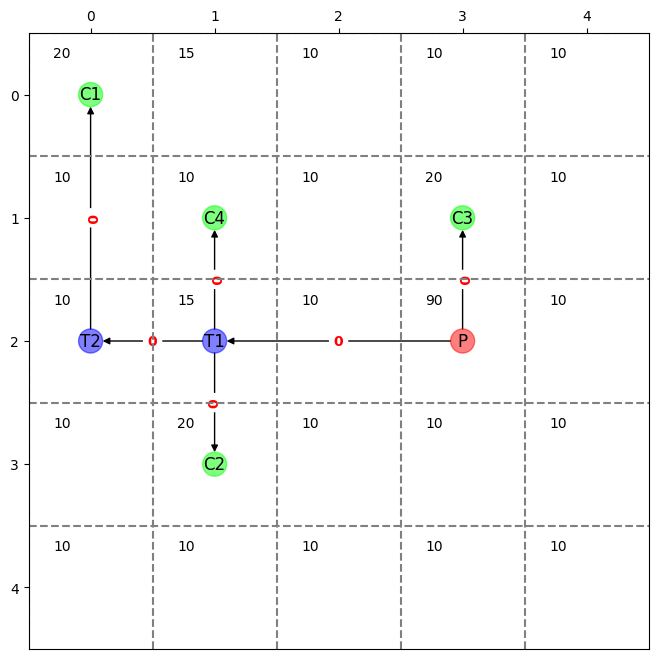

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

# 手动反转x，y坐标，纵向为x横向为y
def inverse_xy(node_list, edge_list):
    inversed_node_list = []
    inversed_edge_list = []
    for node in node_list:
        node[0] = tuple(reversed(node[0]))
        inversed_node_list.append(node)
    for edge in edge_list:
        edge[0] = tuple(reversed(edge[0]))
        edge[1] = tuple(reversed(edge[1]))
        inversed_edge_list.append(edge)
    return inversed_node_list, inversed_edge_list


figure, ax = plt.subplots(figsize=(8,8))

# 对象创建
G = nx.DiGraph()
pos = {}# 结点位置
# 手动反转x，y坐标，纵向为x横向为y
node_list = [] #  其中元素为[[x,y], node_type, label]
edge_list = [] # 其中元素为[[x1,y1], [x2,y2]]
node_list, edge_list = dfs_tree(map, provider, consumer_vector, transmitter_vector)
node_list, edge_list = inverse_xy(node_list, edge_list)
for node in node_list:
    G.add_node(node[0], node_type=node[1], label=node[2]) # 结点用其坐标标识
    pos[node[0]] = node[0]
for edge in edge_list:
    G.add_edge(edge[0], edge[1])

# 合并后的图
merged_G = nx.DiGraph()
pos = {}# 结点位置
for node in G.nodes:
    if G.nodes[node]["node_type"] == "EMPTY":
        # merged_G.add_node(node, **G.nodes[node])
        in_edge = list(G.in_edges(node))[0]
        out_edge = list(G.out_edges(node))[0]
        merged_G.add_edge(in_edge[0], out_edge[1])
    else:
        # 对于其他结点保留
        merged_G.add_node(node, **G.nodes[node])
        pos[node] = node
        # 入边和出边不与Empty相邻的边保留
        in_edges_list = []
        for edge in G.in_edges(node):
            if not G.nodes[edge[0]]["node_type"] == "EMPTY":
                in_edges_list.append(edge)
        out_edges_list = []
        for edge in G.out_edges(node):
            if  not G.nodes[edge[1]]["node_type"] == "EMPTY":
                out_edges_list.append(edge)
        merged_G.add_edges_from(in_edges_list)
        merged_G.add_edges_from(out_edges_list)

# 添加消息格式
for source_obj in [provider] + transmitter_vector:
    source = source_obj.y, source_obj.x
    target_vector = source_obj.target_vector
    for target_item in target_vector:
        if target_item[0] == 0:
            # Transmitter
            target_obj = transmitter_vector[target_item[1]-1]
        else:
            # Consumer
            target_obj = consumer_vector[target_item[1]-1]
        target = (target_obj.y, target_obj.x)
        merged_G.add_edge(source, target, format=target_item[2])
    
# 结点绘制
color_dict = {
    "PROVIDER" : "#FF000080",
    "CONSUMER" : "#00FF0080",
    "TRANSMITTER" : "#0000FF80",
}
node_color_list = [color_dict[i] for i in nx.get_node_attributes(merged_G, "node_type").values()]
node_label_dict =  nx.get_node_attributes(merged_G, "label")
edge_label_dict = nx.get_edge_attributes(merged_G, "format")
nx.draw(merged_G, pos, node_color=node_color_list, labels=node_label_dict) # 绘制结点
nx.draw_networkx_edge_labels(merged_G, pos, edge_labels=edge_label_dict, font_color="red", font_weight="bold") 

# 网格线设置
# ax.grid(color="grey", linestyle="--") # 整数位置画网格
N = map.N
positions = [i-0.5 for i in range(N)]
for pos in positions:
    ax.axhline(y=pos, color="grey", linestyle="--")
    ax.axvline(x=pos, color="grey", linestyle="--")

# 网格中单元格代价绘制
for i in range(N):
    for j in range(N):
        node = map.node_matrix[i][j]
        text = str(node.weight)
        x = node.x-0.3
        y = node.y-0.3
        ax.text(y, x, text) # 稍微偏移

# 刻度设置
ax.axis("on")
ax.set_xlim(left=-0.5, right=N-0.5) # 设置坐标轴范围，自动设置为整数
ax.set_ylim(bottom=N-0.5, top=-0.5)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.xaxis.tick_top() # 坐标原点移动到左上角
plt.show()